In [31]:
!pip install tensorflow==2.4.1 tensorflow-quantum

In [32]:
import cirq
import sympy
import numpy as np
import tensorflow as tf
import tensorflow_quantum as tfq

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
np.random.seed(1234)

In [33]:
(x_train, y_trai), (x_test, y_tes) = tf.keras.datasets.cifar10.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train/255.0, x_test/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 50000
Number of original test examples: 10000


In [34]:
y_train=[]
for i in range(len(y_trai)):

  y_train.append( y_trai[i][0] )

y_test=[]
for i in range(len(y_tes)):

  y_test.append( y_tes[i][0] )

y_train = np.array (y_train)
y_test = np.array (y_test)

In [35]:
def filter_03(x, y):
    keep = (y == 0) | (y == 3)
    x, y = x[keep], y[keep]
    y = y == 0
    return x,y

In [36]:
x_train, y_train = filter_03(x_train, y_train)
x_test, y_test = filter_03(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 10000
Number of filtered test examples: 2000


False


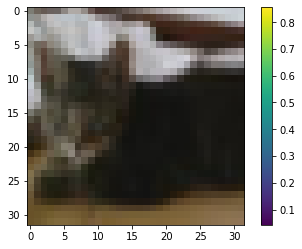

In [37]:
print(y_train[0])

plt.imshow(x_train[0, :, :])
plt.colorbar()

In [38]:
def truncate_x(x_train, x_test, n_components=10):
  """Perform PCA on image dataset keeping the top `n_components` components."""
  n_points_train = tf.gather(tf.shape(x_train), 0)
  n_points_test = tf.gather(tf.shape(x_test), 0)

  # Flatten to 1D
  x_train = tf.reshape(x_train, [n_points_train, -1])
  x_test = tf.reshape(x_test, [n_points_test, -1])

  # Normalize.
  feature_mean = tf.reduce_mean(x_train, axis=0)
  x_train_normalized = x_train - feature_mean
  x_test_normalized = x_test - feature_mean

  # Truncate.
  e_values, e_vectors = tf.linalg.eigh(
      tf.einsum('ji,jk->ik', x_train_normalized, x_train_normalized))
  return tf.einsum('ij,jk->ik', x_train_normalized, e_vectors[:,-n_components:]), \
    tf.einsum('ij,jk->ik', x_test_normalized, e_vectors[:, -n_components:])

In [39]:
DATASET_DIM = 10
x_train, x_test = truncate_x(x_train, x_test, n_components=DATASET_DIM)
print(f'New datapoint dimension:', len(x_train[0]))

New datapoint dimension: 10


In [40]:
N_TRAIN = 1000
N_TEST = 200
x_train, x_test = x_train[:N_TRAIN], x_test[:N_TEST]
y_train, y_test = y_train[:N_TRAIN], y_test[:N_TEST]

In [41]:
print("New number of training examples:", len(x_train))
print("New number of test examples:", len(x_test))

New number of training examples: 1000
New number of test examples: 200


In [42]:
def single_qubit_wall(qubits, rotations):
  """Prepare a single qubit X,Y,Z rotation wall on `qubits`."""
  wall_circuit = cirq.Circuit()
  for i, qubit in enumerate(qubits):
    for j, gate in enumerate([cirq.X, cirq.Y, cirq.Z]):
      wall_circuit.append(gate(qubit) ** rotations[i][j])

  return wall_circuit

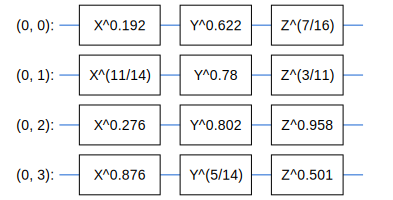

In [43]:
SVGCircuit(single_qubit_wall(
    cirq.GridQubit.rect(1,4), np.random.uniform(size=(4, 3))))

In [44]:
def v_theta(qubits):
  """Prepares a circuit that generates V(\theta)."""
  ref_paulis = [
      cirq.X(q0) * cirq.X(q1) + \
      cirq.Y(q0) * cirq.Y(q1) + \
      cirq.Z(q0) * cirq.Z(q1) for q0, q1 in zip(qubits, qubits[1:])
  ]
  exp_symbols = list(sympy.symbols('ref_0:'+str(len(ref_paulis))))
  return tfq.util.exponential(ref_paulis, exp_symbols), exp_symbols

Symbols found in circuit:[ref_0]


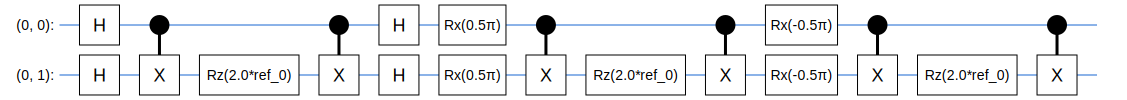

In [45]:
test_circuit, test_symbols = v_theta(cirq.GridQubit.rect(1, 2))
print(f'Symbols found in circuit:{test_symbols}')
SVGCircuit(test_circuit)

In [46]:
def prepare_pqk_circuits(qubits, classical_source, n_trotter=10):
  """Prepare the pqk feature circuits around a dataset."""
  n_qubits = len(qubits)
  n_points = len(classical_source)

  # Prepare random single qubit rotation wall.
  random_rots = np.random.uniform(-2, 2, size=(n_qubits, 3))
  initial_U = single_qubit_wall(qubits, random_rots)

  # Prepare parametrized V
  V_circuit, symbols = v_theta(qubits)
  exp_circuit = cirq.Circuit(V_circuit for t in range(n_trotter))
  
  # Convert to `tf.Tensor`
  initial_U_tensor = tfq.convert_to_tensor([initial_U])
  initial_U_splat = tf.tile(initial_U_tensor, [n_points])

  full_circuits = tfq.layers.AddCircuit()(
      initial_U_splat, append=exp_circuit)
  # Replace placeholders in circuits with values from `classical_source`.
  return tfq.resolve_parameters(
      full_circuits, tf.convert_to_tensor([str(x) for x in symbols]),
      tf.convert_to_tensor(classical_source*(n_qubits/3)/n_trotter))

In [47]:
qubits = cirq.GridQubit.rect(1, DATASET_DIM + 1)
q_x_train_circuits = prepare_pqk_circuits(qubits, x_train)
q_x_test_circuits = prepare_pqk_circuits(qubits, x_test)

In [48]:
def get_pqk_features(qubits, data_batch):
  """Get PQK features based on above construction."""
  ops = [[cirq.X(q), cirq.Y(q), cirq.Z(q)] for q in qubits]
  ops_tensor = tf.expand_dims(tf.reshape(tfq.convert_to_tensor(ops), -1), 0)
  batch_dim = tf.gather(tf.shape(data_batch), 0)
  ops_splat = tf.tile(ops_tensor, [batch_dim, 1])
  exp_vals = tfq.layers.Expectation()(data_batch, operators=ops_splat)
  rdm = tf.reshape(exp_vals, [batch_dim, len(qubits), -1])
  return rdm

In [49]:
x_train_pqk = get_pqk_features(qubits, q_x_train_circuits)
x_test_pqk = get_pqk_features(qubits, q_x_test_circuits)
print('New PQK training dataset has shape:', x_train_pqk.shape)
print('New PQK testing dataset has shape:', x_test_pqk.shape)

New PQK training dataset has shape: (1000, 11, 3)
New PQK testing dataset has shape: (200, 11, 3)


In [50]:
def compute_kernel_matrix(vecs, gamma):
  """Computes d[i][j] = e^ -gamma * (vecs[i] - vecs[j]) ** 2 """
  scaled_gamma = gamma / (
      tf.cast(tf.gather(tf.shape(vecs), 1), tf.float32) * tf.math.reduce_std(vecs))
  return scaled_gamma * tf.einsum('ijk->ij',(vecs[:,None,:] - vecs) ** 2)

def get_spectrum(datapoints, gamma=1.0):
  """Compute the eigenvalues and eigenvectors of the kernel of datapoints."""
  KC_qs = compute_kernel_matrix(datapoints, gamma)
  S, V = tf.linalg.eigh(KC_qs)
  S = tf.math.abs(S)
  return S, V

In [51]:
S_pqk, V_pqk = get_spectrum(
    tf.reshape(tf.concat([x_train_pqk, x_test_pqk], 0), [-1, len(qubits) * 3]))

S_original, V_original = get_spectrum(
    tf.cast(tf.concat([x_train, x_test], 0), tf.float32), gamma=0.005)

print('Eigenvectors of pqk kernel matrix:', V_pqk)
print('Eigenvectors of original kernel matrix:', V_original)

Eigenvectors of pqk kernel matrix: tf.Tensor(
[[ 0.02556718  0.00768413  0.00197367 ...  0.07530307 -0.01960875
   0.02719977]
 [ 0.01770481 -0.00984319 -0.02866882 ... -0.00072626 -0.6818408
   0.0200118 ]
 [ 0.02269827 -0.02487514 -0.00872482 ... -0.10491876  0.01171913
   0.0228814 ]
 ...
 [-0.05020167  0.00879047 -0.00258445 ...  0.01233826 -0.00847624
   0.03129106]
 [-0.06547318  0.01878772 -0.00442906 ...  0.03352804  0.0303734
   0.0357622 ]
 [-0.04468397 -0.01446903  0.01193379 ...  0.03361928 -0.01317962
   0.02858297]], shape=(1200, 1200), dtype=float32)
Eigenvectors of original kernel matrix: tf.Tensor(
[[ 3.4689892e-02 -3.9853401e-02 -4.2038932e-02 ...  6.0135353e-02
  -2.4427854e-02  3.4564879e-02]
 [ 3.7354674e-02  2.0159408e-02  1.0199435e-02 ... -2.6009066e-04
  -7.4891526e-01  2.8748117e-02]
 [ 1.9476874e-02  2.7302338e-02 -4.5219634e-02 ... -6.7100883e-01
  -8.6603668e-03  3.8624268e-02]
 ...
 [-8.0402512e-03 -7.7783358e-03  4.4654772e-02 ...  5.3088897e-04
   5.0321

In [52]:
def get_stilted_dataset(S, V, S_2, V_2, lambdav=1.1):
  """Prepare new labels that maximize geometric distance between kernels."""
  S_diag = tf.linalg.diag(S ** 0.5)
  S_2_diag = tf.linalg.diag(S_2 / (S_2 + lambdav) ** 2)
  scaling = S_diag @ tf.transpose(V) @ \
            V_2 @ S_2_diag @ tf.transpose(V_2) @ \
            V @ S_diag

  # Generate new lables using the largest eigenvector.
  _, vecs = tf.linalg.eig(scaling)
  new_labels = tf.math.real(
      tf.einsum('ij,j->i', tf.cast(V @ S_diag, tf.complex64), vecs[-1])).numpy()
  # Create new labels and add some small amount of noise.
  final_y = new_labels > np.median(new_labels)
  noisy_y = (final_y ^ (np.random.uniform(size=final_y.shape) > 0.95))
  return noisy_y

In [53]:
y_relabel = get_stilted_dataset(S_pqk, V_pqk, S_original, V_original)
y_train_new, y_test_new = y_relabel[:N_TRAIN], y_relabel[N_TRAIN:]

In [54]:
#docs_infra: no_execute
def create_pqk_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(32, activation='sigmoid', input_shape=[len(qubits) * 3,]))
    model.add(tf.keras.layers.Dense(1))
    return model

pqk_model = create_pqk_model()
pqk_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
              metrics=['accuracy'])

pqk_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 32)                1088      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


In [55]:
#docs_infra: no_execute
pqk_history = pqk_model.fit(tf.reshape(x_train_pqk, [N_TRAIN, -1]),
          y_train_new,
          batch_size=32,
          epochs=1000,
          verbose=0,
          validation_data=(tf.reshape(x_test_pqk, [N_TEST, -1]), y_test_new))

In [56]:
import numpy
cvscores = []
scores = pqk_model.evaluate(tf.reshape(x_test_pqk, [N_TEST, -1]) , y_test_new)
print("%s: %.2f%%" % (pqk_model.metrics_names[1], scores[1]*100))
cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

7/7 [==============================] - 0s 2ms/step - loss: 2.5760 - accuracy: 0.8750
accuracy: 87.50%
87.50% (+/- 0.00%)


In [57]:
#docs_infra: no_execute
def create_fair_classical_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(32, activation='sigmoid', input_shape=[DATASET_DIM,]))
    model.add(tf.keras.layers.Dense(1))
    return model

model = create_fair_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.03),
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 32)                352       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________


In [58]:
#docs_infra: no_execute
classical_history = model.fit(x_train,
          y_train_new,
          batch_size=32,
          epochs=1000,
          verbose=0,
          validation_data=(x_test, y_test_new))

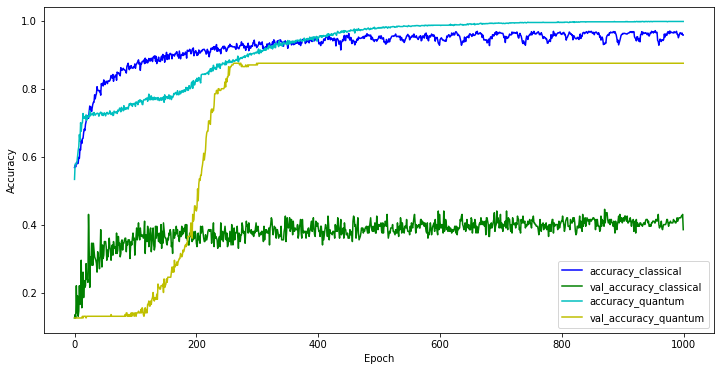

In [59]:
#docs_infra: no_execute
plt.figure(figsize=(12,6))
plt.plot(classical_history.history['accuracy'], label='accuracy_classical', color='b')
plt.plot(classical_history.history['val_accuracy'], label='val_accuracy_classical', color='g')
plt.plot(pqk_history.history['accuracy'], label='accuracy_quantum', color='c')
plt.plot(pqk_history.history['val_accuracy'], label='val_accuracy_quantum', color='y')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [60]:
import numpy
cvscores = []
scores = model.evaluate(x_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

accuracy: 53.00%
53.00% (+/- 0.00%)
